# **Human Emotion Classification**

In [ ]:
import tensorflow as tf

tf.__version__

'2.9.2'

## **시작**

In [ ]:
import pandas as pd     # pandas DataFrame 이용
import numpy as np      
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

import random

path = "/content/drive/MyDrive/Emotion_dataset/"

prior_data = pd.read_csv(path + 'icml_face_data.csv')     # Google Drive에 있는 dataset 로드. 전처리 전의 초기 데이터. Pandas DataFrame

print(prior_data.head())    # 첫번째 데이터 임의 출력

# 0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral

print("\n prior_Data의 colum 종류와 개수")
print(prior_data['emotion'].value_counts())

# pixel column은 앞에 한 칸 띄워져있음. 이점 유의...' pixels' 로 써야됨

disgust_idx = prior_data[prior_data['emotion'] == 1].index
# fear_idx = prior_data[prior_data['emotion'] == 2].index
# surprise_idx = prior_data[prior_data['emotion'] == 5].index
# dataset1 = prior_data.drop(disgust_idx)      # disgust 데이터가 부족해서 제거한 후의 데이터셋
# dataset2 = dataset1.drop(fear_idx)      # disgust 데이터가 부족해서 제거한 후의 데이터셋
dataset = prior_data.drop(disgust_idx)      # disgust 데이터가 부족해서 제거한 후의 데이터셋

print("\n dataset의 column 종류와 개수")
print(dataset['emotion'].value_counts())

# 0 = Angry, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral

print("\n첫번째 데이터")
print(dataset[' pixels'][0])
print(dataset[' pixels'].shape)
print("\n첫번째 데이터 길이(str)")
print(len(dataset[' pixels'][0]))    # 48X48은 2304인데, 데이터 길이가 8287이 나옴. str 되어있어서 데이터 타입을 numpy로 바꿔줘야함.

print("\n첫번째 데이터 길이(numpy)")
temp = np.fromstring(dataset[' pixels'][0], dtype=int, sep=' ')    # 공백 기준으로 데이터를 int로 바꾸어 전체 데이터는 numpy(행렬)가 됨.
print(len(temp))

def Preprocessing(data):
    image = np.zeros(shape=(len(data), 48, 48)) # 빈 넘파이형태 (48*48)
    label = np.array(list(map(int, data['emotion']))) 
    for i, row in enumerate(data.index):
        df = np.fromstring(data[' pixels'][row], dtype=int, sep=' ') # 공백으로 구분된 데이터를 넘파이로 변경
        df = np.reshape(df, (48, 48)) 
        image[i] = df
    return image, label

# def Preprocessing(data):
#     image = np.zeros(shape=(len(data), 48, 48)) # 빈 넘파이형태 (48*48)
#     clean_img = np.zeros(shape=(len(data), 144, 144)) # 빈 넘파이형태 (48*48)
#     label = np.array(list(map(int, data['emotion']))) 
#     for i, row in enumerate(data.index):
#         df = np.fromstring(data[' pixels'][row], dtype=int, sep=' ') # 공백으로 구분된 데이터를 넘파이로 변경
#         df = np.reshape(df, (48, 48)) 
#         image[i] = df
#         img_resize = cv2.resize(image[i], dsize=(144,144), interpolation=cv2.INTER_CUBIC)
#         kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

#         clean_img[i] = cv2.filter2D(img_resize, -1, kernel)

#     return clean_img, label



   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

 prior_Data의 colum 종류와 개수
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

 dataset의 column 종류와 개수
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

첫번째 데이터
70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 

## **데이터 전처리**

In [ ]:
# 데이터 구분 
x_train, y_train = Preprocessing(dataset[dataset[' Usage'] == 'Training'])
x_val, y_val = Preprocessing(dataset[dataset[' Usage'] == 'PrivateTest'])
x_test, y_test = Preprocessing(dataset[dataset[' Usage'] == 'PublicTest'])

# 확인
print(x_train.shape, x_val.shape, x_test.shape)

(28273, 48, 48) (3534, 48, 48) (3533, 48, 48)


## **첫번째 이미지 확인**

label:  0


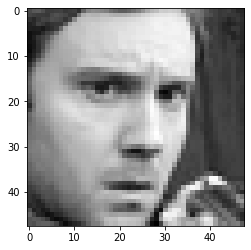

In [ ]:
# 첫번째 이미지 확인 
plt.imshow(x_train[0], cmap='gray')
print("label: ", y_train[0])

## **지난 모델**

In [ ]:
# 모델2
model = Sequential([
    Flatten(input_shape=(48,48)),
    BatchNormalization(),
    Dense(128, activation='relu'), 
    BatchNormalization(),
    Dense(7, activation='softmax')

])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# 학습
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=70, batch_size=64, shuffle=True)
result = model.evaluate(x_test, y_test);

Epoch 1/70
400/400 [==============================] - 2s 4ms/step - loss: 1.6502 - accuracy: 0.3554 - val_loss: 1.5089 - val_accuracy: 0.3829
Epoch 2/70
400/400 [==============================] - 2s 4ms/step - loss: 1.4706 - accuracy: 0.4057 - val_loss: 1.4914 - val_accuracy: 0.3867
Epoch 3/70
400/400 [==============================] - 2s 4ms/step - loss: 1.4265 - accuracy: 0.4279 - val_loss: 1.4623 - val_accuracy: 0.4018
Epoch 4/70
400/400 [==============================] - 2s 4ms/step - loss: 1.3903 - accuracy: 0.4422 - val_loss: 1.4665 - val_accuracy: 0.3977
Epoch 5/70
400/400 [==============================] - 2s 4ms/step - loss: 1.3597 - accuracy: 0.4552 - val_loss: 1.4869 - val_accuracy: 0.4069
Epoch 6/70
400/400 [==============================] - 2s 4ms/step - loss: 1.3281 - accuracy: 0.4736 - val_loss: 1.4771 - val_accuracy: 0.4084
Epoch 7/70
400/400 [==============================] - 2s 5ms/step - loss: 1.2998 - accuracy: 0.4880 - val_loss: 1.4543 - val_accuracy: 0.4233
Epoch 

## **CNN Model**

In [ ]:
img_height = 48;
img_width = 48;
ch = 1;

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, ch)),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    # BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    # BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.1),
    Dense(7, activation='softmax')
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# model.summary();
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# 학습
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=70, batch_size=64, shuffle=True)
result = model.evaluate(x_test, y_test);

Epoch 1/70
442/442 [==============================] - 14s 11ms/step - loss: 1.6064 - accuracy: 0.3406 - val_loss: 1.4404 - val_accuracy: 0.4264
Epoch 2/70
442/442 [==============================] - 4s 9ms/step - loss: 1.3541 - accuracy: 0.4633 - val_loss: 1.3133 - val_accuracy: 0.4901
Epoch 3/70
442/442 [==============================] - 4s 9ms/step - loss: 1.2577 - accuracy: 0.5057 - val_loss: 1.2233 - val_accuracy: 0.5190
Epoch 4/70
442/442 [==============================] - 4s 8ms/step - loss: 1.2011 - accuracy: 0.5310 - val_loss: 1.1554 - val_accuracy: 0.5453
Epoch 5/70
442/442 [==============================] - 4s 9ms/step - loss: 1.1549 - accuracy: 0.5487 - val_loss: 1.1289 - val_accuracy: 0.5634
Epoch 6/70
442/442 [==============================] - 4s 8ms/step - loss: 1.1137 - accuracy: 0.5696 - val_loss: 1.1057 - val_accuracy: 0.5608
Epoch 7/70
442/442 [==============================] - 4s 8ms/step - loss: 1.0892 - accuracy: 0.5761 - val_loss: 1.1290 - val_accuracy: 0.5676
Epoc

## **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2])
cm=cm / cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

## **차트**

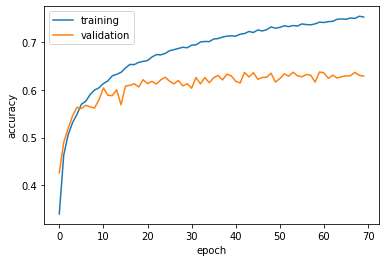

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])

## **테스트 결과**

In [ ]:
print('test result loss rate : ', result[0])
print('test result accuracy rate : ', result[1])

test result loss rate :  1.1039031744003296
test result accuracy rate :  0.6167563199996948
